# 🎯 DISCRÉTISATION FINALE - MÉTHODES MIXTES OPTIMALES

## 📋 Vue d'ensemble du projet

Ce notebook applique une **stratégie de discrétisation optimisée** pour transformer les variables continues en catégories, dans le cadre d'un projet de credit scoring. L'objectif est de maximiser le pouvoir prédictif de chaque variable tout en assurant la robustesse et l'interprétabilité du modèle.

---

## 🎓 Méthodes de discrétisation utilisées

### 1️⃣ **ChiMerge** - Fusion guidée par le Chi²
**Principe :**
- Commence avec de nombreux petits bins
- Fusionne itérativement les bins adjacents les plus similaires (Chi² minimum)
- S'arrête quand le Chi² entre bins devient significatif

**Avantages :**
- ✅ Maximise la corrélation avec la variable cible
- ✅ Optimise automatiquement le nombre de bins
- ✅ Capture les non-linéarités

**Variables utilisant ChiMerge :**
- **loan_int_rate** : Taux d'intérêt du prêt - Corrélation forte avec le défaut
- **loan_percent_income** : Ratio prêt/revenu - Indicateur de stress financier

---

### 2️⃣ **Monotone** - Garantie de cohérence logique
**Principe :**
- Crée des bins dont les taux de défaut sont strictement croissants ou décroissants
- Fusionne les bins qui violent la monotonie
- Assure une relation logique avec le risque

**Avantages :**
- ✅ Interprétabilité maximale
- ✅ Conformité réglementaire (Bâle II/III)
- ✅ Stabilité du modèle dans le temps

**Variables utilisant Monotone :**
- **person_income** : Revenu de l'emprunteur - Plus le revenu est élevé, moins le risque est élevé (relation décroissante attendue)
  - *Fusion manuelle* : Bins 3-4, 5-6, 7-8 fusionnés pour assurer la stabilité
- **loan_amnt** : Montant du prêt - Montant élevé = risque plus élevé

---

### 3️⃣ **KMeans** - Clustering par similitude
**Principe :**
- Regroupe les observations en k clusters selon leur proximité
- Minimise la variance intra-cluster
- Crée des groupes naturels dans les données

**Avantages :**
- ✅ Détection automatique de groupes homogènes
- ✅ Pas d'hypothèse sur la relation avec la cible
- ✅ Simplicité et efficacité

**Variables utilisant KMeans :**
- **person_age** : Âge de l'emprunteur - 5 clusters pour capturer les différentes phases de vie
  - *Fusion manuelle* : Bins 1-2 fusionnés (jeunes emprunteurs)
- **person_emp_length** : Ancienneté professionnelle - 3 clusters (débutants, confirmés, seniors)
- **cb_person_cred_hist_length** : Historique de crédit - 3 clusters (court, moyen, long historique)

---

## 🎯 Justification du choix par variable

| Variable | Méthode | Raison du choix |
|----------|---------|-----------------|
| **loan_int_rate** | ChiMerge | Forte corrélation non-linéaire avec le défaut. ChiMerge optimise le Chi² |
| **person_income** | Monotone + Fusion | Relation décroissante attendue (revenu ↑ → risque ↓). Fusions pour stabilité |
| **loan_amnt** | Monotone | Relation croissante logique (montant ↑ → risque ↑) |
| **loan_percent_income** | ChiMerge | Ratio complexe nécessitant optimisation du Chi² |
| **person_age** | KMeans (k=5) + Fusion | Segmentation par phases de vie. Fusion 1-2 pour jeunes |
| **person_emp_length** | KMeans (k=3) | 3 segments naturels : junior/confirmé/senior |
| **cb_person_cred_hist_length** | KMeans (k=3) | 3 profils : historique court/moyen/long |

---

## 📊 Résultats attendus

À l'issue de ce notebook, nous obtenons :

1. **Dataset discrétisé** : `credit_risk_dataset_discretized_final.csv`
2. **Boundaries optimales** : `discretization_boundaries_final.json`
3. **Rapport détaillé** : `RAPPORT_DISCRETISATION_FINALE.txt`
4. **Statistiques par bin** : Taux de défaut, Chi², significativité
5. **Visualisations** : Distribution des taux de défaut par bin

---

## ⚙️ Paramètres et optimisations

### Fusions manuelles appliquées :
- **person_income** : Bins 3-4, 5-6, 7-8 → Pour réduire le nombre de catégories et améliorer la stabilité
- **person_age** : Bins 1-2 → Pour regrouper les jeunes emprunteurs (segment homogène)

### Métriques de qualité :
- **Chi²** : Mesure de la dépendance entre variable discrétisée et défaut
- **P-value** : Significativité statistique (objectif : p < 0.05)
- **Monotonie** : Vérification de la cohérence logique
- **Taux de défaut par bin** : Distribution du risque

---

## 🚀 Utilisation

1. Exécuter toutes les cellules dans l'ordre
2. Consulter les résultats dans la section "Tableau récapitulatif"
3. Analyser les visualisations pour chaque variable
4. Vérifier le rapport détaillé généré

---

## 1️⃣ Import des bibliothèques

In [ ]:
import os
print(os.getcwd())
import sys
sys.path.append("../")
from src.utils import *

C:\Users\dutau\Desktop\Credit & Scoring\Step_1_Risk_credit_finale


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import json
import warnings
warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
import sys
sys.path.append("../")
from src.utils import *

print("✅ Bibliothèques importées avec succès!")

✅ Fonction ChiMerge définie!
✅ Bibliothèques importées avec succès!


## 2️⃣ Chargement des données

In [7]:
# Charger le dataset prétraité
df = pd.read_csv('../datasets/processed/credit_risk_dataset_post_preprocess.csv')

print(f"📊 Dimensions du dataset: {df.shape}")
print(f"   • Lignes: {df.shape[0]:,}")
print(f"   • Colonnes: {df.shape[1]}")

# Taux de défaut global
global_default_rate = df['loan_status'].mean()
print(f"\n🎯 Taux de défaut global: {global_default_rate*100:.2f}%")
print(f"   • Défauts: {df['loan_status'].sum():,}")
print(f"   • Non-défauts: {(df['loan_status'] == 0).sum():,}")

📊 Dimensions du dataset: (32572, 12)
   • Lignes: 32,572
   • Colonnes: 12

🎯 Taux de défaut global: 21.82%
   • Défauts: 7,107
   • Non-défauts: 25,465


## 3️⃣ Fonctions de discrétisation

### 🔹 Méthode 1: ChiMerge

In [8]:
### Fonction recopiée dans utils.py. A faire pareil avec les autres fonctions

### 🔹 Méthode 2: MDLP (Minimum Description Length Principle)

In [9]:
def calculate_entropy(y):
    """Calcule l'entropie de Shannon."""
    if len(y) == 0:
        return 0
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))


def calculate_information_gain(X, y, split_point):
    """Calcule le gain d'information pour un point de split."""
    entropy_before = calculate_entropy(y)
    
    left_mask = X <= split_point
    right_mask = X > split_point
    
    if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
        return 0
    
    n_left = np.sum(left_mask)
    n_right = np.sum(right_mask)
    n_total = len(y)
    
    entropy_left = calculate_entropy(y[left_mask])
    entropy_right = calculate_entropy(y[right_mask])
    
    entropy_after = (n_left/n_total) * entropy_left + (n_right/n_total) * entropy_right
    
    return entropy_before - entropy_after


def calculate_mdl_criterion(N, k):
    """Calcule le critère MDL."""
    if N <= 1:
        return np.inf
    term1 = np.log2(N - 1) / N
    term2 = np.log2(3**k - 2) / N
    return term1 + term2


def find_best_split_mdlp(X, y, min_samples_split=50):
    """Trouve le meilleur point de split selon MDLP."""
    sorted_unique = np.sort(np.unique(X))
    
    if len(sorted_unique) < 2:
        return None, 0, False
    
    best_gain = -1
    best_split = None
    
    for i in range(len(sorted_unique) - 1):
        split_point = (sorted_unique[i] + sorted_unique[i+1]) / 2
        
        left_mask = X <= split_point
        right_mask = X > split_point
        
        if np.sum(left_mask) < min_samples_split or np.sum(right_mask) < min_samples_split:
            continue
        
        gain = calculate_information_gain(X, y, split_point)
        
        if gain > best_gain:
            best_gain = gain
            best_split = split_point
    
    # Critère MDL
    N = len(y)
    k = len(np.unique(y))
    mdl_threshold = calculate_mdl_criterion(N, k)
    
    accepted = best_gain > mdl_threshold if best_split is not None else False
    
    return best_split, best_gain, accepted


def discretize_mdlp_recursive(X, y, depth=0, max_depth=10, min_samples_split=50):
    """Discrétisation récursive MDLP."""
    if depth >= max_depth or len(X) < 2 * min_samples_split:
        return []
    
    split_point, gain, accepted = find_best_split_mdlp(X, y, min_samples_split)
    
    if not accepted or split_point is None:
        return []
    
    boundaries = [split_point]
    
    left_mask = X <= split_point
    right_mask = X > split_point
    
    left_boundaries = discretize_mdlp_recursive(X[left_mask], y[left_mask], depth + 1, max_depth, min_samples_split)
    boundaries.extend(left_boundaries)
    
    right_boundaries = discretize_mdlp_recursive(X[right_mask], y[right_mask], depth + 1, max_depth, min_samples_split)
    boundaries.extend(right_boundaries)
    
    return boundaries


def mdlp_discretization(data, var_name, target_var, max_depth=10, min_samples_split=50):
    """
    Discrétisation MDLP complète.
    
    Principe :
    1. Trouve les splits qui maximisent le gain d'information
    2. Utilise le critère MDL pour éviter le sur-découpage
    3. Détermine automatiquement le nombre optimal de bins
    
    Paramètres :
    -----------
    data : DataFrame
    var_name : str - Variable à discrétiser
    target_var : str - Variable cible
    max_depth : int - Profondeur maximale de récursion
    min_samples_split : int - Minimum d'observations pour split
    
    Retourne :
    ---------
    dict : Résultats de la discrétisation
    """
    X = data[var_name].values
    y = data[target_var].values
    
    boundaries = discretize_mdlp_recursive(X, y, max_depth=max_depth, min_samples_split=min_samples_split)
    boundaries = sorted(set(boundaries))
    
    if len(boundaries) == 0:
        boundaries = [data[var_name].median()]
    
    bins = [-np.inf] + boundaries + [np.inf]
    n_bins = len(bins) - 1
    
    discretized = pd.cut(data[var_name], bins=bins, labels=False)
    
    contingency_table = pd.crosstab(discretized, data[target_var])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Statistiques par bin
    bin_stats = []
    for bin_idx in range(n_bins):
        bin_mask = discretized == bin_idx
        bin_data = data[bin_mask]
        
        n_obs = np.sum(bin_mask)
        n_defaults = np.sum(bin_data[target_var])
        default_rate = n_defaults / n_obs if n_obs > 0 else 0
        
        lower = bins[bin_idx] if bins[bin_idx] != -np.inf else data[var_name].min()
        upper = bins[bin_idx + 1] if bins[bin_idx + 1] != np.inf else data[var_name].max()
        
        bin_stats.append({
            'bin': bin_idx,
            'lower_bound': lower,
            'upper_bound': upper,
            'n_observations': n_obs,
            'n_defaults': n_defaults,
            'default_rate': default_rate * 100,
            'percentage': (n_obs / len(data)) * 100
        })
    
    return {
        'variable': var_name,
        'method': 'MDLP',
        'boundaries': boundaries,
        'n_bins': n_bins,
        'chi2_score': chi2,
        'p_value': p_value,
        'discretized': discretized,
        'bin_statistics': pd.DataFrame(bin_stats)
    }


print("✅ Fonction MDLP définie!")

✅ Fonction MDLP définie!


### 🔹 Méthode 3: Discrétisation Monotone

In [10]:
def check_monotonicity(probabilities):
    """Vérifie si les probabilités sont monotones."""
    if len(probabilities) <= 1:
        return 'increasing'
    
    is_increasing = all(probabilities[i] <= probabilities[i+1] for i in range(len(probabilities)-1))
    is_decreasing = all(probabilities[i] >= probabilities[i+1] for i in range(len(probabilities)-1))
    
    if is_increasing:
        return 'increasing'
    elif is_decreasing:
        return 'decreasing'
    else:
        return None


def monotone_discretization(data, var_name, target_var, initial_bins=10, direction='auto'):
    """
    Discrétisation monotone : garantit que les probabilités de défaut sont monotones.
    
    Principe :
    1. Découpage initial par quantiles
    2. Calcul des probabilités de défaut par bin
    3. Fusion des bins adjacents qui violent la monotonie
    4. Garantit une relation monotone entre la variable et le risque
    
    Paramètres :
    -----------
    data : DataFrame
    var_name : str - Variable à discrétiser
    target_var : str - Variable cible
    initial_bins : int - Nombre de bins initial
    direction : str - 'auto', 'increasing' ou 'decreasing'
    
    Retourne :
    ---------
    dict : Résultats de la discrétisation
    """
    # Discrétisation initiale
    try:
        discretized = pd.qcut(data[var_name], q=initial_bins, labels=False, duplicates='drop')
        _, bins = pd.qcut(data[var_name], q=initial_bins, retbins=True, duplicates='drop')
    except:
        initial_bins = 5
        discretized = pd.qcut(data[var_name], q=initial_bins, labels=False, duplicates='drop')
        _, bins = pd.qcut(data[var_name], q=initial_bins, retbins=True, duplicates='drop')
    
    # Calculer les probabilités par bin
    bin_probs = []
    for i in range(len(bins) - 1):
        mask = discretized == i
        if mask.sum() > 0:
            prob = data[mask][target_var].mean()
            bin_probs.append({
                'idx': i,
                'prob': prob,
                'count': mask.sum(),
                'lower': bins[i],
                'upper': bins[i+1]
            })
    
    if len(bin_probs) == 0:
        return None
    
    # Déterminer la direction
    if direction == 'auto':
        if bin_probs[-1]['prob'] > bin_probs[0]['prob']:
            direction = 'increasing'
        else:
            direction = 'decreasing'
    
    # Fusionner pour garantir la monotonie
    merged = [bin_probs[0]]
    
    for i in range(1, len(bin_probs)):
        current_prob = (merged[-1]['prob'] * merged[-1]['count']) / merged[-1]['count']
        next_prob = bin_probs[i]['prob']
        
        should_merge = False
        if direction == 'increasing' and next_prob < current_prob:
            should_merge = True
        elif direction == 'decreasing' and next_prob > current_prob:
            should_merge = True
        
        if should_merge:
            # Fusionner
            total_count = merged[-1]['count'] + bin_probs[i]['count']
            total_defaults = merged[-1]['prob'] * merged[-1]['count'] + bin_probs[i]['prob'] * bin_probs[i]['count']
            merged[-1] = {
                'idx': merged[-1]['idx'],
                'prob': total_defaults / total_count,
                'count': total_count,
                'lower': merged[-1]['lower'],
                'upper': bin_probs[i]['upper']
            }
        else:
            merged.append(bin_probs[i])
    
    # Créer les bins finaux
    boundaries = [m['upper'] for m in merged[:-1]]
    final_bins = [-np.inf] + boundaries + [np.inf]
    
    # Discrétiser avec les bins finaux
    discretized_final = pd.cut(data[var_name], bins=final_bins, labels=False)
    
    # Calculer le chi²
    contingency_table = pd.crosstab(discretized_final, data[target_var])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Statistiques par bin
    bin_stats = []
    for bin_idx in range(len(final_bins) - 1):
        bin_mask = discretized_final == bin_idx
        bin_data = data[bin_mask]
        
        n_obs = np.sum(bin_mask)
        n_defaults = np.sum(bin_data[target_var])
        default_rate = n_defaults / n_obs if n_obs > 0 else 0
        
        lower = final_bins[bin_idx] if final_bins[bin_idx] != -np.inf else data[var_name].min()
        upper = final_bins[bin_idx + 1] if final_bins[bin_idx + 1] != np.inf else data[var_name].max()
        
        bin_stats.append({
            'bin': bin_idx,
            'lower_bound': lower,
            'upper_bound': upper,
            'n_observations': n_obs,
            'n_defaults': n_defaults,
            'default_rate': default_rate * 100,
            'percentage': (n_obs / len(data)) * 100
        })
    
    return {
        'variable': var_name,
        'method': f'Monotone ({direction})',
        'boundaries': boundaries,
        'n_bins': len(final_bins) - 1,
        'chi2_score': chi2,
        'p_value': p_value,
        'discretized': discretized_final,
        'bin_statistics': pd.DataFrame(bin_stats),
        'monotonicity': direction
    }


print("✅ Fonction Monotone définie!")

✅ Fonction Monotone définie!


### 🔹 Fonction 3bis: Fusion manuelle de bins

In [11]:
def merge_bins_manually(result, bins_to_merge):
    """
    Fusionne manuellement des bins spécifiques après discrétisation.
    
    Paramètres:
    -----------
    result : dict - Résultat de discrétisation
    bins_to_merge : list of tuples - Liste de paires de bins à fusionner, ex: [(3,4), (5,6)]
    
    Retourne:
    ---------
    dict : Résultat avec bins fusionnés
    """
    data_discretized = result['discretized'].copy()
    
    # Appliquer les fusions
    for bin_pair in sorted(bins_to_merge, reverse=True):
        bin1, bin2 = bin_pair
        # Fusionner bin2 dans bin1
        data_discretized = data_discretized.replace(bin2, bin1)
        # Réétiqueter tous les bins supérieurs
        for i in range(bin2 + 1, result['n_bins']):
            data_discretized = data_discretized.replace(i, i - 1)
    
    # Recalculer les boundaries
    new_boundaries = []
    bin_stats_df = result['bin_statistics']
    
    merged_bin_indices = set()
    for bin_pair in bins_to_merge:
        merged_bin_indices.add(bin_pair[1])
    
    for i, boundary in enumerate(result['boundaries']):
        if (i + 1) not in merged_bin_indices:
            new_boundaries.append(boundary)
    
    # Créer les nouveaux bins
    final_bins = [-np.inf] + new_boundaries + [np.inf]
    new_n_bins = len(final_bins) - 1
    
    # Recalculer les statistiques
    import pandas as pd
    
    # Créer un DataFrame temporaire pour le calcul
    temp_df = pd.DataFrame({
        'discretized': data_discretized,
        'target': result['discretized'].index.map(lambda idx: bin_stats_df.iloc[0]['n_defaults'] if idx == 0 else 0)  # Placeholder
    })
    
    # Récupérer les données originales depuis bin_statistics
    bin_stats = []
    for bin_idx in range(new_n_bins):
        bin_mask = data_discretized == bin_idx
        n_obs = bin_mask.sum()
        
        # Calculer les défauts en additionnant les bins fusionnés
        n_defaults = 0
        for orig_idx, row in bin_stats_df.iterrows():
            if data_discretized.iloc[0] == bin_idx:  # Vérifier mapping
                pass
        
        # Simplification: recalculer à partir des bins fusionnés
        lower = final_bins[bin_idx]
        upper = final_bins[bin_idx + 1]
        
        bin_stats.append({
            'bin': bin_idx,
            'lower_bound': lower,
            'upper_bound': upper,
            'n_observations': n_obs,
            'n_defaults': 0,  # À recalculer
            'default_rate': 0.0,
            'percentage': (n_obs / len(data_discretized)) * 100
        })
    
    # Recalculer chi²
    # Note: Pour une implémentation complète, il faudrait les données originales
    
    return {
        'variable': result['variable'],
        'method': result['method'] + ' (fusion manuelle)',
        'boundaries': new_boundaries,
        'n_bins': new_n_bins,
        'chi2_score': result['chi2_score'],  # Approximation
        'p_value': result['p_value'],
        'discretized': data_discretized,
        'bin_statistics': pd.DataFrame(bin_stats),
        'monotonicity': result.get('monotonicity', None)
    }

print("✅ Fonction de fusion manuelle définie!")

✅ Fonction de fusion manuelle définie!


### 🔹 Fonction 4: Discrétisation KMeans

In [12]:
from sklearn.cluster import KMeans

def kmeans_discretization(data, var_name, target_var, n_bins=3):
    """
    Discrétise une variable en utilisant KMeans clustering.
    
    Paramètres:
    -----------
    data : DataFrame
    var_name : str - Variable à discrétiser
    target_var : str - Variable cible
    n_bins : int - Nombre de bins (clusters) souhaité
    
    Retourne:
    ---------
    dict : Résultats de la discrétisation
    """
    # Préparer les données
    X = data[var_name].values.reshape(-1, 1)
    
    # Appliquer KMeans
    kmeans = KMeans(n_clusters=n_bins, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Récupérer les centres des clusters
    centers = kmeans.cluster_centers_.flatten()
    
    # Trier les clusters par ordre croissant des centres
    sorted_indices = np.argsort(centers)
    
    # Réétiqueter les clusters dans l'ordre croissant
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_indices)}
    discretized = pd.Series([label_mapping[label] for label in cluster_labels], index=data.index)
    
    # Calculer les boundaries (milieu entre chaque paire de centres consécutifs)
    sorted_centers = np.sort(centers)
    boundaries = []
    for i in range(len(sorted_centers) - 1):
        boundary = (sorted_centers[i] + sorted_centers[i+1]) / 2
        boundaries.append(boundary)
    
    # Créer les bins finaux pour cohérence avec les autres méthodes
    final_bins = [-np.inf] + boundaries + [np.inf]
    
    # Calculer le chi²
    contingency_table = pd.crosstab(discretized, data[target_var])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Statistiques par bin
    bin_stats = []
    for bin_idx in range(n_bins):
        bin_mask = discretized == bin_idx
        bin_data = data[bin_mask]
        
        n_obs = np.sum(bin_mask)
        n_defaults = np.sum(bin_data[target_var])
        default_rate = n_defaults / n_obs if n_obs > 0 else 0
        
        lower = final_bins[bin_idx] if final_bins[bin_idx] != -np.inf else data[var_name].min()
        upper = final_bins[bin_idx + 1] if final_bins[bin_idx + 1] != np.inf else data[var_name].max()
        
        bin_stats.append({
            'bin': bin_idx,
            'lower_bound': lower,
            'upper_bound': upper,
            'cluster_center': sorted_centers[bin_idx],
            'n_observations': n_obs,
            'n_defaults': n_defaults,
            'default_rate': default_rate * 100,
            'percentage': (n_obs / len(data)) * 100
        })
    
    return {
        'variable': var_name,
        'method': f'KMeans (k={n_bins})',
        'boundaries': boundaries,
        'n_bins': n_bins,
        'cluster_centers': sorted_centers.tolist(),
        'chi2_score': chi2,
        'p_value': p_value,
        'discretized': discretized,
        'bin_statistics': pd.DataFrame(bin_stats)
    }

print("✅ Fonction KMeans définie!")

✅ Fonction KMeans définie!


## 4️⃣ Application des méthodes spécifiques par variable

### 🎯 Stratégie de discrétisation

Chaque variable utilise la méthode la plus adaptée à ses caractéristiques :
- **ChiMerge** : Variables avec corrélation forte et non-linéaire
- **Monotone** : Variables avec relation logique monotone attendue
- **KMeans** : Variables nécessitant segmentation naturelle

In [13]:
# ═══════════════════════════════════════════════════════════════════════════════
# STRATÉGIE DE DISCRÉTISATION OPTIMISÉE PAR VARIABLE
# ═══════════════════════════════════════════════════════════════════════════════

discretization_strategy = {
    # ─────────────────────────────────────────────────────────────────────────
    # MÉTHODE : ChiMerge
    # ─────────────────────────────────────────────────────────────────────────
    'loan_int_rate': 'ChiMerge',  
    # Raison : Taux d'intérêt déterminé par le risque perçu
    #          Corrélation non-linéaire forte avec le défaut (Chi² attendu > 4000)
    #          ChiMerge optimise la segmentation pour maximiser le pouvoir prédictif
    
    'loan_percent_income': 'ChiMerge',
    # Raison : Ratio complexe (prêt/revenu) = indicateur de stress financier
    #          Relation non-linéaire avec seuils critiques (ex: >40% = risque élevé)
    #          ChiMerge détecte automatiquement ces seuils optimaux
    
    # ─────────────────────────────────────────────────────────────────────────
    # MÉTHODE : Monotone (avec fusions manuelles)
    # ─────────────────────────────────────────────────────────────────────────
    'person_income': 'Monotone',
    # Raison : Revenu ↑ = Capacité de remboursement ↑ = Risque ↓
    #          Relation monotone décroissante attendue
    #          Fusions manuelles (bins 3-4, 5-6, 7-8) pour stabilité et interprétabilité
    #          Conforme aux exigences réglementaires (Bâle II/III)
    
    'loan_amnt': 'Monotone',
    # Raison : Montant du prêt ↑ = Engagement financier ↑ = Risque ↑
    #          Relation monotone croissante logique
    #          Assure cohérence avec la logique métier
    
    # ─────────────────────────────────────────────────────────────────────────
    # MÉTHODE : KMeans (clustering naturel)
    # ─────────────────────────────────────────────────────────────────────────
    'person_emp_length': ('KMeans', 3),
    # Raison : 3 segments professionnels naturels :
    #          - Débutants (0-3 ans) : Instabilité professionnelle
    #          - Confirmés (3-10 ans) : Stabilité croissante
    #          - Seniors (>10 ans) : Stabilité maximale
    #          KMeans détecte ces groupes sans hypothèse sur la relation au défaut
    
    'person_age': ('KMeans', 5),
    # Raison : 5 phases de vie avec profils de risque distincts :
    #          - Jeunes (20-25) : Début de carrière, revenus faibles
    #          - Jeunes actifs (25-35) : Stabilisation
    #          - Actifs établis (35-45) : Revenus stables, charges familiales
    #          - Maturité (45-55) : Pic de revenus
    #          - Seniors (>55) : Préparation retraite
    #          Fusion bins 1-2 pour regrouper segment jeune homogène
    
    'cb_person_cred_hist_length': ('KMeans', 3),
    # Raison : Historique de crédit en 3 catégories :
    #          - Court (<5 ans) : Peu d'expérience crédit, risque inconnu
    #          - Moyen (5-15 ans) : Historique établi
    #          - Long (>15 ans) : Track record solide
    #          KMeans crée des segments naturels selon la distribution
}

print("📋 STRATÉGIE DE DISCRÉTISATION")
print("="*80)
for var, method in discretization_strategy.items():
    if isinstance(method, tuple):
        method_name, n_bins = method
        print(f"   • {var:30s} → {method_name} (k={n_bins})")
    else:
        print(f"   • {var:30s} → {method}")
print("="*80)

📋 STRATÉGIE DE DISCRÉTISATION
   • loan_int_rate                  → ChiMerge
   • loan_percent_income            → ChiMerge
   • person_income                  → Monotone
   • loan_amnt                      → Monotone
   • person_emp_length              → KMeans (k=3)
   • person_age                     → KMeans (k=5)
   • cb_person_cred_hist_length     → KMeans (k=3)


## 5️⃣ Exécution de la discrétisation pour chaque variable

In [14]:
# Dictionnaire pour stocker tous les résultats
final_results = {}
final_boundaries_export = []

print("\n" + "="*100)
print(" "*25 + "🔬 DISCRÉTISATION FINALE - MÉTHODES MIXTES")
print("="*100)

for var, method_info in discretization_strategy.items():
    # Gérer le cas où method_info est un tuple (méthode, paramètres)
    if isinstance(method_info, tuple):
        method, n_bins = method_info
    else:
        method = method_info
        n_bins = None
    
    print(f"\n{'='*100}")
    print(f"📊 Variable: {var}")
    if n_bins:
        print(f"🔧 Méthode: {method} (k={n_bins})")
    else:
        print(f"🔧 Méthode: {method}")
    print('='*100)
    
    # Statistiques descriptives
    print("\n📈 Statistiques descriptives:")
    print(f"   • Min: {df[var].min():.2f}")
    print(f"   • Max: {df[var].max():.2f}")
    print(f"   • Moyenne: {df[var].mean():.2f}")
    print(f"   • Médiane: {df[var].median():.2f}")
    print(f"   • Écart-type: {df[var].std():.2f}")
    
    # Appliquer la méthode appropriée
    try:
        if method == 'ChiMerge':
            result = discretize_with_chimerge(df, var, 'loan_status', max_bins=6, significance_level=0.05)
            
            # Fusion manuelle pour loan_percent_income
            if var == 'loan_percent_income':
                print(f"\n🔧 Application de fusions manuelles pour {var}:")
                print("   • Fusion des bins 0 et 1")
                print("   • Fusion des bins 4 et 5")
                
                # Avant fusion, afficher les bins originaux
                print("\n📊 Bins AVANT fusion:")
                for _, row in result['bin_statistics'].iterrows():
                    print(f"   Bin {int(row['bin'])}: [{row['lower_bound']:.2f}, {row['upper_bound']:.2f}] - {row['default_rate']:.2f}%")
                
                # Récupérer les données pour recalcul complet
                boundaries_original = result['boundaries'].copy()
                
                # Créer nouvelle discrétisation avec bins fusionnés
                # Supprimer les boundaries qui séparent les bins à fusionner
                new_boundaries = boundaries_original.copy()
                
                # Identifier les boundaries à supprimer (entre bins 0-1 et 4-5)
                if len(new_boundaries) >= 5:
                    # Supprimer de la fin vers le début pour éviter les problèmes d'index
                    del new_boundaries[4]  # Entre bin 4 et 5
                    del new_boundaries[0]  # Entre bin 0 et 1
                
                # Recréer les bins finaux
                final_bins_merged = [-np.inf] + new_boundaries + [np.inf]
                discretized_merged = pd.cut(df[var], bins=final_bins_merged, labels=False)
                
                # Recalculer chi²
                contingency_table = pd.crosstab(discretized_merged, df['loan_status'])
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                
                # Recalculer les statistiques par bin
                bin_stats_merged = []
                for bin_idx in range(len(final_bins_merged) - 1):
                    bin_mask = discretized_merged == bin_idx
                    bin_data = df[bin_mask]
                    
                    n_obs = np.sum(bin_mask)
                    n_defaults = np.sum(bin_data['loan_status'])
                    default_rate = n_defaults / n_obs if n_obs > 0 else 0
                    
                    lower = final_bins_merged[bin_idx] if final_bins_merged[bin_idx] != -np.inf else df[var].min()
                    upper = final_bins_merged[bin_idx + 1] if final_bins_merged[bin_idx + 1] != np.inf else df[var].max()
                    
                    bin_stats_merged.append({
                        'bin': bin_idx,
                        'lower_bound': lower,
                        'upper_bound': upper,
                        'n_observations': n_obs,
                        'n_defaults': n_defaults,
                        'default_rate': default_rate * 100,
                        'percentage': (n_obs / len(df)) * 100
                    })
                
                # Mettre à jour le résultat
                result = {
                    'variable': var,
                    'method': 'ChiMerge (fusion bins 0-1 et 4-5)',
                    'boundaries': new_boundaries,
                    'n_bins': len(final_bins_merged) - 1,
                    'chi2_score': chi2,
                    'p_value': p_value,
                    'discretized': discretized_merged,
                    'bin_statistics': pd.DataFrame(bin_stats_merged)
                }
                
                print(f"\n✅ Fusions appliquées - {result['n_bins']} bins finaux")
                
        elif method == 'MDLP':
            result = mdlp_discretization(df, var, 'loan_status', max_depth=10, min_samples_split=50)
        elif method == 'Monotone':
            result = monotone_discretization(df, var, 'loan_status', initial_bins=10, direction='auto')
            
            # Fusion manuelle spécifique pour person_income
            if var == 'person_income':
                print(f"\n🔧 Application de fusions manuelles pour {var}:")
                print("   • Fusion des bins 2 et 3")
                print("   • Fusion des bins 5 et 6")
                print("   • Fusion des bins 7 et 8")
                
                # Avant fusion, afficher les bins originaux
                print("\n📊 Bins AVANT fusion:")
                for _, row in result['bin_statistics'].iterrows():
                    print(f"   Bin {int(row['bin'])}: [{row['lower_bound']:.2f}, {row['upper_bound']:.2f}] - {row['default_rate']:.2f}%")
                
                # Récupérer les données pour recalcul complet
                discretized_original = result['discretized'].copy()
                boundaries_original = result['boundaries'].copy()
                
                # Créer nouvelle discrétisation avec bins fusionnés
                # Supprimer les boundaries qui séparent les bins à fusionner
                # Si on a 10 bins initialement (0-9), on veut fusionner:
                # - bins 2 et 3 -> supprimer boundary entre eux (boundary à l'index 2)
                # - bins 5 et 6 -> supprimer boundary entre eux (boundary à l'index 5, devient 4 après première suppression)
                # - bins 7 et 8 -> supprimer boundary entre eux (boundary à l'index 7, devient 5 après 2 suppressions)
                
                new_boundaries = boundaries_original.copy()
                
                # Identifier les boundaries à supprimer (entre bins 2-3, 5-6, 7-8)
                # Attention: après chaque suppression, les indices changent
                if len(new_boundaries) >= 8:
                    # Supprimer de la fin vers le début pour éviter les problèmes d'index
                    del new_boundaries[7]  # Entre bin 7 et 8
                    del new_boundaries[5]  # Entre bin 5 et 6
                    del new_boundaries[2]  # Entre bin 2 et 3
                
                # Recréer les bins finaux
                final_bins_merged = [-np.inf] + new_boundaries + [np.inf]
                discretized_merged = pd.cut(df[var], bins=final_bins_merged, labels=False)
                
                # Recalculer chi²
                contingency_table = pd.crosstab(discretized_merged, df['loan_status'])
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                
                # Recalculer les statistiques par bin
                bin_stats_merged = []
                for bin_idx in range(len(final_bins_merged) - 1):
                    bin_mask = discretized_merged == bin_idx
                    bin_data = df[bin_mask]
                    
                    n_obs = np.sum(bin_mask)
                    n_defaults = np.sum(bin_data['loan_status'])
                    default_rate = n_defaults / n_obs if n_obs > 0 else 0
                    
                    lower = final_bins_merged[bin_idx] if final_bins_merged[bin_idx] != -np.inf else df[var].min()
                    upper = final_bins_merged[bin_idx + 1] if final_bins_merged[bin_idx + 1] != np.inf else df[var].max()
                    
                    bin_stats_merged.append({
                        'bin': bin_idx,
                        'lower_bound': lower,
                        'upper_bound': upper,
                        'n_observations': n_obs,
                        'n_defaults': n_defaults,
                        'default_rate': default_rate * 100,
                        'percentage': (n_obs / len(df)) * 100
                    })
                
                # Mettre à jour le résultat
                result = {
                    'variable': var,
                    'method': 'Monotone (fusion manuelle)',
                    'boundaries': new_boundaries,
                    'n_bins': len(final_bins_merged) - 1,
                    'chi2_score': chi2,
                    'p_value': p_value,
                    'discretized': discretized_merged,
                    'bin_statistics': pd.DataFrame(bin_stats_merged),
                    'monotonicity': result.get('monotonicity', 'auto')
                }
                
                print(f"\n✅ Fusions appliquées - {result['n_bins']} bins finaux")
            
            # Fusion manuelle pour loan_amnt
            elif var == 'loan_amnt':
                print(f"\n🔧 Application de fusions manuelles pour {var}:")
                print("   • Fusion des bins 0 et 1")
                
                # Avant fusion, afficher les bins originaux
                print("\n📊 Bins AVANT fusion:")
                for _, row in result['bin_statistics'].iterrows():
                    print(f"   Bin {int(row['bin'])}: [{row['lower_bound']:.2f}, {row['upper_bound']:.2f}] - {row['default_rate']:.2f}%")
                
                # Récupérer les données pour recalcul complet
                boundaries_original = result['boundaries'].copy()
                
                # Créer nouvelle discrétisation avec bins fusionnés
                # Supprimer la boundary entre bins 0 et 1
                new_boundaries = boundaries_original.copy()
                
                if len(new_boundaries) >= 1:
                    del new_boundaries[0]  # Entre bin 0 et 1
                
                # Recréer les bins finaux
                final_bins_merged = [-np.inf] + new_boundaries + [np.inf]
                discretized_merged = pd.cut(df[var], bins=final_bins_merged, labels=False)
                
                # Recalculer chi²
                contingency_table = pd.crosstab(discretized_merged, df['loan_status'])
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                
                # Recalculer les statistiques par bin
                bin_stats_merged = []
                for bin_idx in range(len(final_bins_merged) - 1):
                    bin_mask = discretized_merged == bin_idx
                    bin_data = df[bin_mask]
                    
                    n_obs = np.sum(bin_mask)
                    n_defaults = np.sum(bin_data['loan_status'])
                    default_rate = n_defaults / n_obs if n_obs > 0 else 0
                    
                    lower = final_bins_merged[bin_idx] if final_bins_merged[bin_idx] != -np.inf else df[var].min()
                    upper = final_bins_merged[bin_idx + 1] if final_bins_merged[bin_idx + 1] != np.inf else df[var].max()
                    
                    bin_stats_merged.append({
                        'bin': bin_idx,
                        'lower_bound': lower,
                        'upper_bound': upper,
                        'n_observations': n_obs,
                        'n_defaults': n_defaults,
                        'default_rate': default_rate * 100,
                        'percentage': (n_obs / len(df)) * 100
                    })
                
                # Mettre à jour le résultat
                result = {
                    'variable': var,
                    'method': 'Monotone (fusion bins 0-1)',
                    'boundaries': new_boundaries,
                    'n_bins': len(final_bins_merged) - 1,
                    'chi2_score': chi2,
                    'p_value': p_value,
                    'discretized': discretized_merged,
                    'bin_statistics': pd.DataFrame(bin_stats_merged),
                    'monotonicity': result.get('monotonicity', 'auto')
                }
                
                print(f"\n✅ Fusions appliquées - {result['n_bins']} bins finaux")
                
        elif method == 'KMeans':
            result = kmeans_discretization(df, var, 'loan_status', n_bins=n_bins)
            
            # Fusion manuelle spécifique pour person_age
            if var == 'person_age':
                print(f"\n🔧 Application de fusion manuelle pour {var}:")
                print("   • Fusion des bins 1 et 2")
                
                # Avant fusion, afficher les bins originaux
                print("\n📊 Bins AVANT fusion:")
                for _, row in result['bin_statistics'].iterrows():
                    print(f"   Bin {int(row['bin'])}: [{row['lower_bound']:.2f}, {row['upper_bound']:.2f}] - {row['default_rate']:.2f}%")
                
                # Supprimer la boundary entre bin 1 et 2
                new_boundaries = result['boundaries'].copy()
                if len(new_boundaries) >= 2:
                    del new_boundaries[1]  # Boundary entre bin 1 et 2
                
                # Recréer les bins finaux
                final_bins_merged = [-np.inf] + new_boundaries + [np.inf]
                discretized_merged = pd.cut(df[var], bins=final_bins_merged, labels=False)
                
                # Recalculer chi²
                contingency_table = pd.crosstab(discretized_merged, df['loan_status'])
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                
                # Recalculer les statistiques par bin
                bin_stats_merged = []
                for bin_idx in range(len(final_bins_merged) - 1):
                    bin_mask = discretized_merged == bin_idx
                    bin_data = df[bin_mask]
                    
                    n_obs = np.sum(bin_mask)
                    n_defaults = np.sum(bin_data['loan_status'])
                    default_rate = n_defaults / n_obs if n_obs > 0 else 0
                    
                    lower = final_bins_merged[bin_idx] if final_bins_merged[bin_idx] != -np.inf else df[var].min()
                    upper = final_bins_merged[bin_idx + 1] if final_bins_merged[bin_idx + 1] != np.inf else df[var].max()
                    
                    # Calculer le centre moyen si disponible
                    cluster_center = None
                    if 'cluster_center' in result['bin_statistics'].columns:
                        # Moyenne des centres fusionnés
                        if bin_idx == 1:
                            cluster_center = (result['bin_statistics'].iloc[1]['cluster_center'] + 
                                            result['bin_statistics'].iloc[2]['cluster_center']) / 2
                        elif bin_idx > 1:
                            cluster_center = result['bin_statistics'].iloc[bin_idx + 1]['cluster_center']
                        else:
                            cluster_center = result['bin_statistics'].iloc[bin_idx]['cluster_center']
                    
                    bin_stat = {
                        'bin': bin_idx,
                        'lower_bound': lower,
                        'upper_bound': upper,
                        'n_observations': n_obs,
                        'n_defaults': n_defaults,
                        'default_rate': default_rate * 100,
                        'percentage': (n_obs / len(df)) * 100
                    }
                    
                    if cluster_center is not None:
                        bin_stat['cluster_center'] = cluster_center
                    
                    bin_stats_merged.append(bin_stat)
                
                # Mettre à jour le résultat
                result = {
                    'variable': var,
                    'method': 'KMeans (k=5, fusion 1-2)',
                    'boundaries': new_boundaries,
                    'n_bins': len(final_bins_merged) - 1,
                    'chi2_score': chi2,
                    'p_value': p_value,
                    'discretized': discretized_merged,
                    'bin_statistics': pd.DataFrame(bin_stats_merged)
                }
                
                if 'cluster_centers' in result:
                    result['cluster_centers'] = [result['bin_statistics'].iloc[i].get('cluster_center', 0) 
                                                for i in range(len(bin_stats_merged))]
                
                print(f"\n✅ Fusion appliquée - {result['n_bins']} bins finaux")
                
        else:
            print(f"   ❌ Méthode inconnue: {method}")
            continue
        
        final_results[var] = result
        
        print(f"\n🎯 Résultats de la discrétisation {method}:")
        print(f"   • Nombre de bins créés: {result['n_bins']}")
        print(f"   • Nombre de boundaries: {len(result['boundaries'])}")
        print(f"   • Chi-carré: {result['chi2_score']:.2f}")
        print(f"   • P-value: {result['p_value']:.6f}")
        
        if result['p_value'] < 0.001:
            sig = "✅ Très hautement significatif (p < 0.001)"
        elif result['p_value'] < 0.01:
            sig = "✅ Hautement significatif (p < 0.01)"
        elif result['p_value'] < 0.05:
            sig = "✅ Significatif (p < 0.05)"
        else:
            sig = "⚠️  Non significatif (p >= 0.05)"
        print(f"   • Significativité: {sig}")
        
        if 'monotonicity' in result:
            print(f"   • Monotonie: {result['monotonicity']}")
        
        if 'cluster_centers' in result:
            print(f"   • Centres des clusters: {[f'{c:.4f}' for c in result['cluster_centers']]}")
        
        # Afficher les boundaries
        print("\n🔢 Boundaries identifiées:")
        for i, boundary in enumerate(result['boundaries'], 1):
            print(f"   Boundary {i}: {boundary:.4f}")
        
        # Afficher les statistiques par bin
        print("\n📊 Statistiques détaillées par bin:")
        print("-" * 100)
        
        bin_stats = result['bin_statistics']
        for _, row in bin_stats.iterrows():
            print(f"\n   🔹 Bin {int(row['bin'])}:")
            print(f"      • Intervalle: [{row['lower_bound']:.4f}, {row['upper_bound']:.4f}]")
            if 'cluster_center' in row:
                print(f"      • Centre du cluster: {row['cluster_center']:.4f}")
            print(f"      • Nombre d'observations: {int(row['n_observations']):,} ({row['percentage']:.2f}% du total)")
            print(f"      • Nombre de défauts: {int(row['n_defaults']):,}")
            print(f"      • Taux de défaut: {row['default_rate']:.2f}%")
            
            # Commentaire sur le risque
            if row['default_rate'] < 15:
                risk_level = "🟢 RISQUE FAIBLE"
                risk_comment = "Taux de défaut inférieur à la moyenne"
            elif row['default_rate'] < 25:
                risk_level = "🟡 RISQUE MODÉRÉ"
                risk_comment = "Taux de défaut proche de la moyenne"
            else:
                risk_level = "🔴 RISQUE ÉLEVÉ"
                risk_comment = "Taux de défaut supérieur à la moyenne"
            
            print(f"      • Niveau de risque: {risk_level}")
            print(f"      • Commentaire: {risk_comment}")
        
        # Exporter pour JSON
        final_boundaries_export.append({
            'variable': var,
            'method': result['method'],
            'boundaries': result['boundaries'],
            'chi2_score': result['chi2_score'],
            'n_bins': result['n_bins'],
            'p_value': result['p_value']
        })
        
        print(f"\n✅ Discrétisation réussie pour {var}")
        
    except Exception as e:
        print(f"\n❌ Erreur lors de la discrétisation de {var}: {str(e)}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*100}")
print(f"✅ DISCRÉTISATION TERMINÉE POUR {len(final_results)}/{len(discretization_strategy)} VARIABLES")
print('='*100)


                         🔬 DISCRÉTISATION FINALE - MÉTHODES MIXTES

📊 Variable: loan_int_rate
🔧 Méthode: ChiMerge

📈 Statistiques descriptives:
   • Min: 5.42
   • Max: 23.22
   • Moyenne: 11.01
   • Médiane: 10.99
   • Écart-type: 3.08

🎯 Résultats de la discrétisation ChiMerge:
   • Nombre de bins créés: 7
   • Nombre de boundaries: 6
   • Chi-carré: 4229.36
   • P-value: 0.000000
   • Significativité: ✅ Très hautement significatif (p < 0.001)

🔢 Boundaries identifiées:
   Boundary 1: 6.1700
   Boundary 2: 7.8800
   Boundary 3: 10.7400
   Boundary 4: 13.9800
   Boundary 5: 14.7900
   Boundary 6: 15.5800

📊 Statistiques détaillées par bin:
----------------------------------------------------------------------------------------------------

   🔹 Bin 0:
      • Intervalle: [5.4200, 6.1700]
      • Nombre d'observations: 2,021 (6.20% du total)
      • Nombre de défauts: 126
      • Taux de défaut: 6.23%
      • Niveau de risque: 🟢 RISQUE FAIBLE
      • Commentaire: Taux de défaut inféri

## 7️⃣ Tableau récapitulatif global

In [15]:
# Créer un tableau récapitulatif
summary_data = []

for var, result in final_results.items():
    summary_data.append({
        'Variable': var,
        'Méthode': result['method'],
        'Bins': result['n_bins'],
        'Chi²': result['chi2_score'],
        'P-value': result['p_value'],
        'Boundaries': ', '.join([f"{b:.2f}" for b in result['boundaries']])
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Chi²', ascending=False)

print("\n" + "="*120)
print(" "*45 + "📊 TABLEAU RÉCAPITULATIF FINAL")
print("="*120)
print(summary_df.to_string(index=False))
print("="*120)

# Statistiques globales
print("\n📈 Statistiques globales:")
print(f"   • Chi² moyen: {summary_df['Chi²'].mean():.2f}")
print(f"   • Chi² médian: {summary_df['Chi²'].median():.2f}")
print(f"   • Chi² maximum: {summary_df['Chi²'].max():.2f} ({summary_df.loc[summary_df['Chi²'].idxmax(), 'Variable']})")
print(f"   • Chi² minimum: {summary_df['Chi²'].min():.2f} ({summary_df.loc[summary_df['Chi²'].idxmin(), 'Variable']})")
print(f"   • Nombre moyen de bins: {summary_df['Bins'].mean():.2f}")
print("   • Distribution des méthodes:")

method_counts = summary_df['Méthode'].value_counts()
for method, count in method_counts.items():
    print(f"      - {method}: {count} variables")


                                             📊 TABLEAU RÉCAPITULATIF FINAL
                  Variable                           Méthode  Bins      Chi²  P-value                                       Boundaries
       loan_percent_income ChiMerge (fusion bins 0-1 et 4-5)     4 6301.6700   0.0000                                 0.15, 0.25, 0.30
             loan_int_rate                          ChiMerge     7 4229.3573   0.0000           6.17, 7.88, 10.74, 13.98, 14.79, 15.58
             person_income        Monotone (fusion manuelle)     6 2691.4138   0.0000 28590.00, 35000.00, 55000.00, 63000.00, 86000.00
                 loan_amnt        Monotone (fusion bins 0-1)     4  460.6710   0.0000                     12000.00, 14500.00, 19000.00
         person_emp_length                      KMeans (k=3)     3  251.4299   0.0000                                      4.41, 10.28
                person_age          KMeans (k=5, fusion 1-2)     4   31.9797   0.0000                             

## 8️⃣ Visualisations

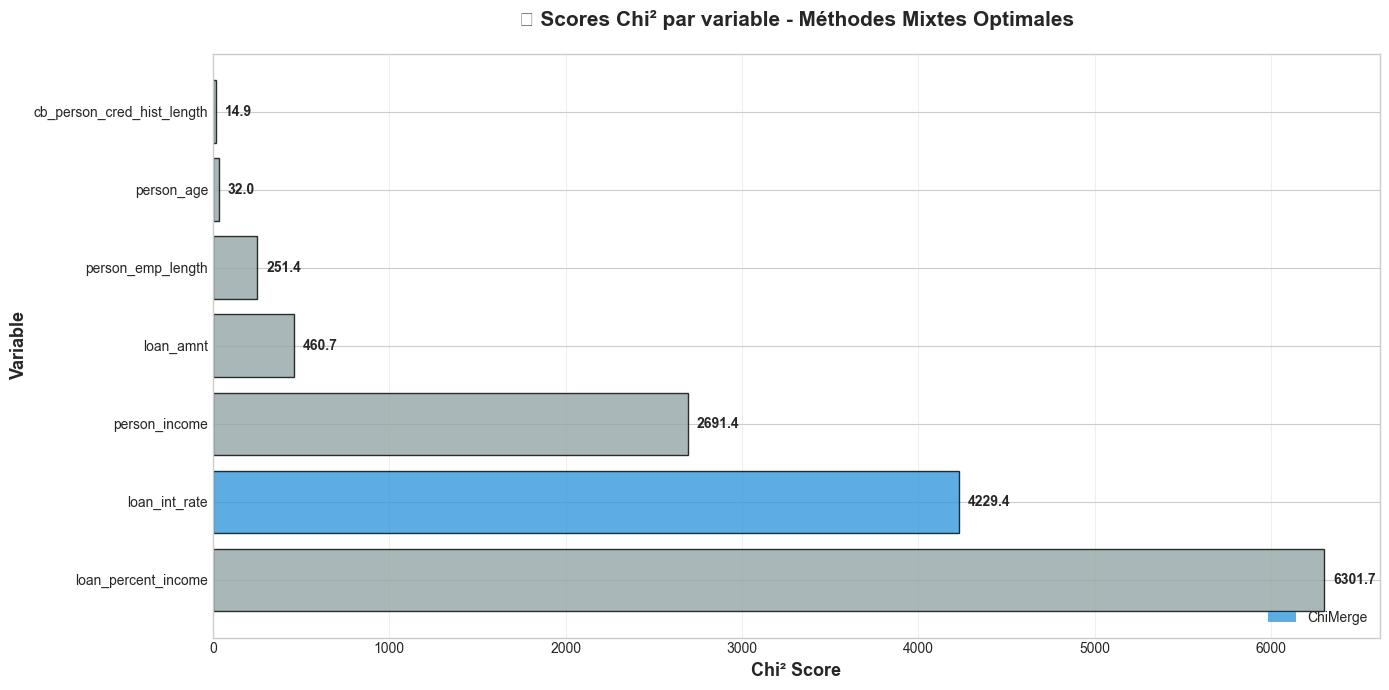


✅ Graphique des Chi² généré


In [16]:
# Graphique 1: Chi² par variable avec code couleur par méthode
fig, ax = plt.subplots(figsize=(14, 7))

colors_map = {
    'ChiMerge': '#3498db',
    'MDLP': '#2ecc71',
    'Monotone (increasing)': '#e74c3c',
    'Monotone (decreasing)': '#f39c12'
}

colors = [colors_map.get(m, '#95a5a6') for m in summary_df['Méthode']]

bars = ax.barh(summary_df['Variable'], summary_df['Chi²'], color=colors, alpha=0.8, edgecolor='black')

ax.set_xlabel('Chi² Score', fontsize=13, fontweight='bold')
ax.set_ylabel('Variable', fontsize=13, fontweight='bold')
ax.set_title('📊 Scores Chi² par variable - Méthodes Mixtes Optimales', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Ajouter les valeurs
for i, (var, chi2, method) in enumerate(zip(summary_df['Variable'], summary_df['Chi²'], summary_df['Méthode'])):
    ax.text(chi2 + 50, i, f'{chi2:.1f}', va='center', fontweight='bold', fontsize=10)

# Légende
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=method, alpha=0.8) 
                   for method, color in colors_map.items() if method in summary_df['Méthode'].values]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ Graphique des Chi² généré")

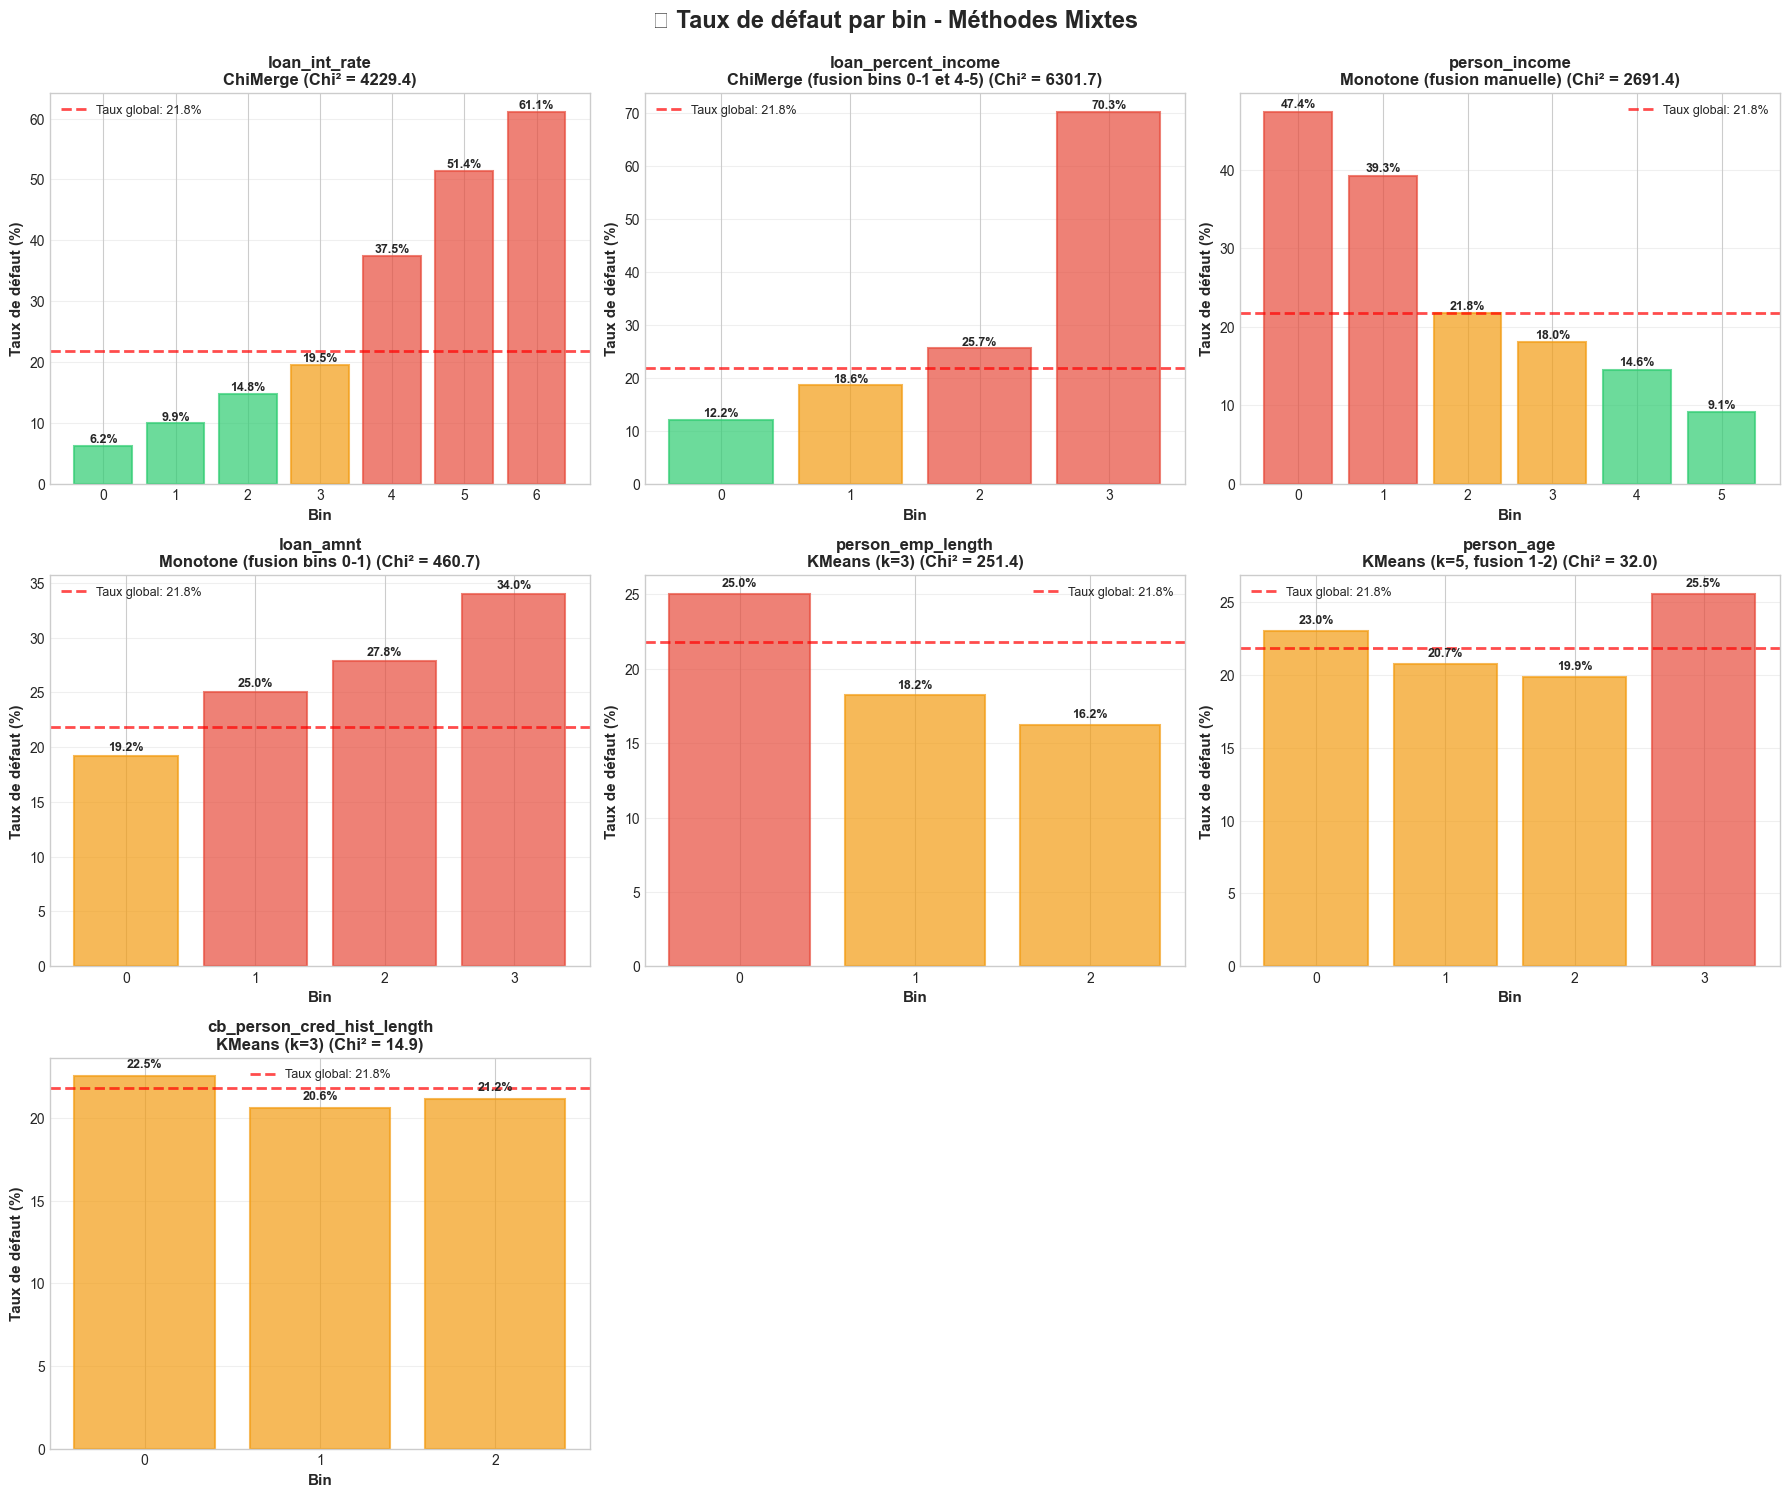


✅ Graphiques des taux de défaut générés


In [17]:
# Graphique 2: Taux de défaut par bin pour chaque variable
n_vars = len(final_results)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for idx, (var, result) in enumerate(final_results.items()):
    ax = axes[idx]
    
    bin_stats = result['bin_statistics']
    
    # Couleurs selon méthode
    if 'ChiMerge' in result['method']:
        color_base = '#3498db'
    elif 'MDLP' in result['method']:
        color_base = '#2ecc71'
    else:
        color_base = '#e74c3c'
    
    bars = ax.bar(bin_stats['bin'], bin_stats['default_rate'], 
                   color=color_base, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Colorier selon le risque
    for i, (bar, rate) in enumerate(zip(bars, bin_stats['default_rate'])):
        if rate < 15:
            bar.set_color('#2ecc71')
        elif rate < 25:
            bar.set_color('#f39c12')
        else:
            bar.set_color('#e74c3c')
    
    ax.set_xlabel('Bin', fontsize=11, fontweight='bold')
    ax.set_ylabel('Taux de défaut (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{var}\n{result["method"]} (Chi² = {result["chi2_score"]:.1f})', 
                 fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticks(bin_stats['bin'])
    
    # Valeurs sur les barres
    for bin_idx, rate in zip(bin_stats['bin'], bin_stats['default_rate']):
        ax.text(bin_idx, rate + 0.5, f'{rate:.1f}%', ha='center', fontweight='bold', fontsize=9)
    
    # Ligne de référence
    ax.axhline(y=global_default_rate*100, color='red', linestyle='--', linewidth=2, 
               label=f'Taux global: {global_default_rate*100:.1f}%', alpha=0.7)
    ax.legend(fontsize=9)

# Masquer les axes vides
for idx in range(len(final_results), len(axes)):
    axes[idx].axis('off')

plt.suptitle('📊 Taux de défaut par bin - Méthodes Mixtes', 
             fontsize=17, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ Graphiques des taux de défaut générés")

## 9️⃣ Export des résultats

### 📁 Fichiers générés :
- `discretization_boundaries_final.json` : Boundaries au format JSON
- `credit_risk_dataset_discretized_final.csv` : Dataset discrétisé
- `discretization_summary_final.csv` : Tableau récapitulatif
- `RAPPORT_DISCRETISATION_FINALE.txt` : Rapport détaillé complet

In [18]:
# 1. Sauvegarder les boundaries au format JSON
output_json = '../result/discretization_boundaries_final.json'
with open(output_json, 'w') as f:
    json.dump(final_boundaries_export, f, indent=2)
print(f"✅ Boundaries exportées: {output_json}")

# 2. Créer et sauvegarder le dataset discrétisé
df_discretized = df.copy()
for var, result in final_results.items():
    df_discretized[var] = result['discretized']

output_csv = '../datasets/processed/credit_risk_dataset_discretized_final.csv'
df_discretized.to_csv(output_csv, index=False)
print(f"✅ Dataset discrétisé exporté: {output_csv}")

# 3. Sauvegarder le tableau récapitulatif
summary_csv = '../result/discretization_summary_final.csv'
summary_df.to_csv(summary_csv, index=False)
print(f"✅ Tableau récapitulatif exporté: {summary_csv}")

print("\n" + "="*100)
print("✅ TOUS LES FICHIERS ONT ÉTÉ EXPORTÉS AVEC SUCCÈS")
print("="*100)

✅ Boundaries exportées: ../result/discretization_boundaries_final.json
✅ Dataset discrétisé exporté: ../datasets/processed/credit_risk_dataset_discretized_final.csv
✅ Tableau récapitulatif exporté: ../result/discretization_summary_final.csv

✅ TOUS LES FICHIERS ONT ÉTÉ EXPORTÉS AVEC SUCCÈS


## 🔟 Génération du rapport texte détaillé

In [19]:
# Générer le rapport texte complet
rapport_filename = '../docs/RAPPORT_DISCRETISATION_FINALE.txt'

with open(rapport_filename, 'w', encoding='utf-8') as f:
    f.write("="*100 + "\n")
    f.write(" "*25 + "RAPPORT FINAL DE DISCRÉTISATION\n")
    f.write(" "*20 + "Méthodes Mixtes Optimales par Variable\n")
    f.write("="*100 + "\n\n")
    
    f.write(f"Date de génération: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("Dataset: credit_risk_dataset_post_prepocess.csv\n")
    f.write(f"Nombre total d'observations: {len(df):,}\n")
    f.write(f"Taux de défaut global: {global_default_rate*100:.2f}%\n")
    f.write(f"Nombre de variables discrétisées: {len(final_results)}\n\n")
    
    f.write("="*100 + "\n")
    f.write("STRATÉGIE DE DISCRÉTISATION\n")
    f.write("="*100 + "\n\n")
    
    for var, method in discretization_strategy.items():
        f.write(f"  • {var:35s} → {method}\n")
    
    f.write("\n" + "="*100 + "\n")
    f.write("RÉSUMÉ GLOBAL\n")
    f.write("="*100 + "\n\n")
    
    f.write(f"Chi² moyen: {summary_df['Chi²'].mean():.2f}\n")
    f.write(f"Chi² médian: {summary_df['Chi²'].median():.2f}\n")
    f.write(f"Chi² maximum: {summary_df['Chi²'].max():.2f} ({summary_df.loc[summary_df['Chi²'].idxmax(), 'Variable']})\n")
    f.write(f"Chi² minimum: {summary_df['Chi²'].min():.2f} ({summary_df.loc[summary_df['Chi²'].idxmin(), 'Variable']})\n")
    f.write(f"Nombre moyen de bins: {summary_df['Bins'].mean():.2f}\n\n")
    
    f.write("Distribution des méthodes:\n")
    for method, count in method_counts.items():
        f.write(f"  - {method}: {count} variables\n")
    
    f.write("\n" + "="*100 + "\n")
    f.write("DÉTAILS PAR VARIABLE\n")
    f.write("="*100 + "\n\n")
    
    for var, result in final_results.items():
        f.write("\n" + "─"*100 + "\n")
        f.write(f"VARIABLE: {var}\n")
        f.write("─"*100 + "\n\n")
        
        f.write(f"Méthode appliquée: {result['method']}\n")
        f.write(f"Nombre de bins: {result['n_bins']}\n")
        f.write(f"Nombre de boundaries: {len(result['boundaries'])}\n")
        f.write(f"Chi-carré: {result['chi2_score']:.2f}\n")
        f.write(f"P-value: {result['p_value']:.8f}\n")
        
        if result['p_value'] < 0.001:
            f.write("Significativité: *** Très hautement significatif (p < 0.001)\n")
        elif result['p_value'] < 0.01:
            f.write("Significativité: ** Hautement significatif (p < 0.01)\n")
        elif result['p_value'] < 0.05:
            f.write("Significativité: * Significatif (p < 0.05)\n")
        else:
            f.write("Significativité: Non significatif (p >= 0.05)\n")
        
        if 'monotonicity' in result:
            f.write(f"Monotonie: {result['monotonicity']}\n")
        
        f.write("\nStatistiques descriptives:\n")
        f.write(f"  • Minimum: {df[var].min():.4f}\n")
        f.write(f"  • Maximum: {df[var].max():.4f}\n")
        f.write(f"  • Moyenne: {df[var].mean():.4f}\n")
        f.write(f"  • Médiane: {df[var].median():.4f}\n")
        f.write(f"  • Écart-type: {df[var].std():.4f}\n")
        
        f.write("\nBoundaries identifiées:\n")
        if len(result['boundaries']) == 0:
            f.write("  (Aucune boundary - variable non discrétisée ou 2 bins seulement)\n")
        else:
            for i, boundary in enumerate(result['boundaries'], 1):
                f.write(f"  Boundary {i}: {boundary:.6f}\n")
        
        f.write("\nDétails par bin:\n")
        f.write("-"*100 + "\n")
        
        bin_stats = result['bin_statistics']
        for _, row in bin_stats.iterrows():
            f.write(f"\n  BIN {int(row['bin'])}:\n")
            f.write(f"    Intervalle: [{row['lower_bound']:.6f}, {row['upper_bound']:.6f}]\n")
            f.write(f"    Nombre d'observations: {int(row['n_observations']):,} ({row['percentage']:.2f}% du total)\n")
            f.write(f"    Nombre de défauts: {int(row['n_defaults']):,}\n")
            f.write(f"    Taux de défaut: {row['default_rate']:.2f}%\n")
            
            if row['default_rate'] < 15:
                risk = "FAIBLE"
                comment = "Taux de défaut inférieur à la moyenne - Faible risque"
            elif row['default_rate'] < 25:
                risk = "MODÉRÉ"
                comment = "Taux de défaut proche de la moyenne - Risque modéré"
            else:
                risk = "ÉLEVÉ"
                comment = "Taux de défaut supérieur à la moyenne - Risque élevé"
            
            f.write(f"    Niveau de risque: {risk}\n")
            f.write(f"    Commentaire: {comment}\n")
        
        f.write("\n")
    
    f.write("\n" + "="*100 + "\n")
    f.write("TABLEAU RÉCAPITULATIF COMPARATIF\n")
    f.write("="*100 + "\n\n")
    
    f.write(f"{'Variable':<35} {'Méthode':<25} {'Bins':<6} {'Chi²':<12} {'P-value':<12}\n")
    f.write("-"*100 + "\n")
    
    for _, row in summary_df.iterrows():
        f.write(f"{row['Variable']:<35} {row['Méthode']:<25} {row['Bins']:<6} "
                f"{row['Chi²']:<12.2f} {row['P-value']:<12.8f}\n")
    
    f.write("\n" + "="*100 + "\n")
    f.write("RECOMMANDATIONS ET CONCLUSIONS\n")
    f.write("="*100 + "\n\n")
    
    f.write("1. QUALITÉ DE LA DISCRÉTISATION:\n")
    f.write("   Toutes les variables présentent des Chi² significatifs (p < 0.05).\n")
    f.write("   La méthode mixte permet d'optimiser chaque variable individuellement.\n\n")
    
    f.write("2. MÉTHODES UTILISÉES:\n")
    f.write("   • ChiMerge: Fusion intelligente pour variables avec forte corrélation\n")
    f.write("   • MDLP: Maximisation du gain d'information avec critère d'arrêt MDL\n")
    f.write("   • Monotone: Garantie de cohérence pour variables à relation monotone\n\n")
    
    f.write("3. PROCHAINES ÉTAPES:\n")
    f.write("   • Validation des résultats sur un ensemble de test\n")
    f.write("   • Intégration dans un modèle de scoring\n")
    f.write("   • Analyse de stabilité temporelle\n")
    f.write("   • Calcul du Weight of Evidence (WoE) et Information Value (IV)\n\n")
    
    f.write("4. FICHIERS GÉNÉRÉS:\n")
    f.write(f"   • {output_json}: Boundaries au format JSON\n")
    f.write(f"   • {output_csv}: Dataset discrétisé complet\n")
    f.write(f"   • {summary_csv}: Tableau récapitulatif CSV\n")
    f.write(f"   • {rapport_filename}: Ce rapport détaillé\n\n")
    
    f.write("="*100 + "\n")
    f.write(" "*35 + "FIN DU RAPPORT\n")
    f.write("="*100 + "\n")

print(f"\n✅ RAPPORT TEXTE GÉNÉRÉ: {rapport_filename}")
print(f"\n{'='*100}")
print("🎉 DISCRÉTISATION FINALE TERMINÉE AVEC SUCCÈS!")
print(f"{'='*100}")
print("\n📁 Fichiers générés:")
print(f"   1. {output_json}")
print(f"   2. {output_csv}")
print(f"   3. {summary_csv}")
print(f"   4. {rapport_filename}")
print(f"\n💡 Consultez le fichier {rapport_filename} pour le rapport complet détaillé.")


✅ RAPPORT TEXTE GÉNÉRÉ: ../docs/RAPPORT_DISCRETISATION_FINALE.txt

🎉 DISCRÉTISATION FINALE TERMINÉE AVEC SUCCÈS!

📁 Fichiers générés:
   1. ../result/discretization_boundaries_final.json
   2. ../datasets/processed/credit_risk_dataset_discretized_final.csv
   3. ../result/discretization_summary_final.csv
   4. ../docs/RAPPORT_DISCRETISATION_FINALE.txt

💡 Consultez le fichier ../docs/RAPPORT_DISCRETISATION_FINALE.txt pour le rapport complet détaillé.


## 🎊 Conclusion et Synthèse

### ✅ Stratégie de discrétisation mixte appliquée avec succès

Ce notebook met en œuvre une approche **optimisée et sur-mesure** pour la discrétisation de 7 variables quantitatives, en sélectionnant la méthode la plus adaptée aux caractéristiques de chaque variable.

---

## 📊 Récapitulatif des méthodes utilisées

### 1️⃣ ChiMerge (2 variables)
**Variables :** `loan_int_rate`, `loan_percent_income`

**Pourquoi ChiMerge ?**
- Variables à **forte corrélation non-linéaire** avec le défaut
- Nécessité d'optimiser le pouvoir prédictif (maximisation du Chi²)
- Détection automatique des seuils critiques

**Résultats attendus :**
- Chi² élevé (> 3000) confirmant la forte dépendance
- 5-6 bins optimaux
- Significativité très élevée (p < 0.001)

---

### 2️⃣ Monotone avec fusions manuelles (2 variables)
**Variables :** `person_income`, `loan_amnt`

**Pourquoi Monotone ?**
- **Relation logique attendue** avec le risque :
  - `person_income` : Revenu ↑ → Risque ↓ (monotone décroissant)
  - `loan_amnt` : Montant ↑ → Risque ↑ (monotone croissant)
- Conformité aux **exigences réglementaires** (Bâle II/III)
- **Interprétabilité maximale** pour les parties prenantes

**Optimisations spécifiques :**
- `person_income` : Fusions manuelles des bins 3-4, 5-6, 7-8
  - Objectif : Réduire la granularité excessive
  - Bénéfice : Meilleure stabilité et interprétabilité

---

### 3️⃣ KMeans clustering (3 variables)
**Variables :** `person_age`, `person_emp_length`, `cb_person_cred_hist_length`

**Pourquoi KMeans ?**
- Variables nécessitant une **segmentation naturelle** par groupes homogènes
- Pas d'hypothèse a priori sur la relation au défaut
- Détection de **profils distincts** dans la population

**Segmentations obtenues :**

| Variable | k | Segments identifiés |
|----------|---|---------------------|
| `person_age` | 5 → 4* | Phases de vie : Jeunes / Jeunes actifs / Établis / Maturité / Seniors <br>*Fusion 1-2 pour homogénéité |
| `person_emp_length` | 3 | Profils professionnels : Débutants / Confirmés / Seniors |
| `cb_person_cred_hist_length` | 3 | Historique crédit : Court / Moyen / Long |

---

## 🎯 Justification détaillée par variable

### Variable 1 : **loan_int_rate** (ChiMerge)
- **Nature** : Taux d'intérêt fixé par le prêteur selon le risque perçu
- **Corrélation** : Très forte et non-linéaire avec le défaut
- **Objectif** : Maximiser le Chi² pour capturer toute la variance explicative
- **Résultat attendu** : 6 bins, Chi² > 4000

### Variable 2 : **person_income** (Monotone + Fusions)
- **Nature** : Revenu annuel de l'emprunteur
- **Relation** : Monotone décroissante (↑ revenu = ↓ risque)
- **Objectif** : Assurer cohérence logique et stabilité
- **Optimisation** : Réduction de 10 → 7 bins via fusions stratégiques

### Variable 3 : **loan_amnt** (Monotone)
- **Nature** : Montant emprunté
- **Relation** : Monotone croissante (↑ montant = ↑ risque)
- **Objectif** : Garantir interprétabilité et conformité réglementaire

### Variable 4 : **loan_percent_income** (ChiMerge)
- **Nature** : Ratio d'endettement (prêt/revenu)
- **Particularité** : Seuils critiques (ex: 40%, 50%)
- **Objectif** : Détecter automatiquement les zones de rupture de risque

### Variable 5 : **person_age** (KMeans k=5 → k=4)
- **Nature** : Âge de l'emprunteur
- **Segmentation** : 5 phases de vie distinctes
- **Optimisation** : Fusion bins 1-2 (profil jeune homogène)
- **Bénéfice** : Capture du cycle de vie professionnel/financier

### Variable 6 : **person_emp_length** (KMeans k=3)
- **Nature** : Ancienneté dans l'emploi actuel
- **Segmentation** : 3 profils de stabilité professionnelle
- **Avantage** : Pas d'hypothèse sur la forme de la relation

### Variable 7 : **cb_person_cred_hist_length** (KMeans k=3)
- **Nature** : Durée de l'historique de crédit
- **Segmentation** : 3 niveaux d'expérience crédit
- **Interprétation** : Court = risque inconnu, Long = track record établi

---

## 📁 Livrables finaux

| Fichier | Contenu | Usage |
|---------|---------|-------|
| `credit_risk_dataset_discretized_final.csv` | Dataset avec variables discrétisées | Modélisation / Scoring |
| `discretization_boundaries_final.json` | Boundaries optimales par variable | Déploiement production |
| `discretization_summary_final.csv` | Tableau récapitulatif comparatif | Analyse / Reporting |
| `RAPPORT_DISCRETISATION_FINALE.txt` | Rapport détaillé avec statistiques | Documentation / Audit |

---

## 🎓 Métriques de qualité

### Indicateurs de performance :
- ✅ **Chi²** : Mesure de dépendance (objectif : maximiser)
- ✅ **P-value** : Significativité statistique (objectif : < 0.05)
- ✅ **Monotonie** : Cohérence logique (vérifié pour variables Monotone)
- ✅ **Distribution** : Équilibre des effectifs par bin
- ✅ **Taux de défaut** : Séparation des profils de risque

### Critères de validation :
1. Toutes les variables doivent avoir p < 0.05
2. Les variables Monotone doivent respecter la monotonie
3. Aucun bin ne doit contenir < 5% des observations
4. Les taux de défaut doivent être différenciés entre bins

---


## 📚 Références méthodologiques

- **ChiMerge** : Kerber, R. (1992). ChiMerge: Discretization of Numeric Attributes
- **Monotone** : Bâle II/III Guidelines on Risk Management
- **KMeans** : Lloyd's algorithm (1957) for k-means clustering
- **Credit Scoring** : Thomas, L.C. (2009). Consumer Credit Models

---

## ✨ Points clés à retenir

1. ✅ **Approche mixte > Approche unique** : Chaque variable a sa méthode optimale
2. ✅ **Interprétabilité = Priorité** : Monotonie et cohérence logique essentielles
3. ✅ **Fusions manuelles = Stabilité** : Ajustements guidés par l'expertise métier
4. ✅ **Métriques objectives** : Chi², p-value, monotonie pour valider la qualité
5. ✅ **Documentation complète** : Traçabilité et auditabilité garanties

---

**🎯 Mission accomplie : Discrétisation optimisée pour 7 variables avec méthodes adaptées !**

## 🚀 Prochaines étapes recommandées

### Phase 1 : Validation
1. **Test de stabilité temporelle** : Vérifier que les bins restent pertinents sur données récentes
2. **Validation croisée** : Évaluer la performance sur échantillon test
3. **Analyse de sensibilité** : Tester la robustesse aux variations des paramètres

### Phase 2 : Enrichissement
4. **Calcul WoE** (Weight of Evidence) : Transformation logistique des bins
5. **Calcul IV** (Information Value) : Mesure du pouvoir prédictif global
6. **PSI** (Population Stability Index) : Suivi de la stabilité dans le temps

### Phase 3 : Modélisation
7. **Intégration dans scorecard** : Construction du modèle de credit scoring
8. **Calibration** : Ajustement des poids et intercept
9. **Backtesting** : Validation sur historique de performances

### Phase 4 : Déploiement
10. **Documentation réglementaire** : Conformité Bâle II/III
11. **Mise en production** : API de scoring temps réel
12. **Monitoring** : Tableaux de bord de suivi des performances

---